In [131]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR
from tqdm import tqdm


In [132]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

batch_size = 10000
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [133]:
print(len(train_dataset))

60000


In [134]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 8
        self.encoder = nn.Sequential(
            nn.Conv2d(1,2,(3,3), (2,2)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(338, 250),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(250, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(250, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, 784),
            nn.Unflatten(1, torch.Size([4, 14, 14])),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, (4,4),(2,2), padding = 1),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [135]:
model = Net()
model.to("cuda")

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=338, out_features=250, bias=True)
    (4): ReLU()
  )
  (mu): Sequential(
    (0): Linear(in_features=250, out_features=8, bias=True)
  )
  (log_var): Sequential(
    (0): Linear(in_features=250, out_features=8, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=784, bias=True)
    (1): Unflatten(dim=1, unflattened_size=torch.Size([4, 14, 14]))
    (2): ReLU()
    (3): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [136]:
def loss_f(output, target, mu, log_var):
    BCE = nn.BCELoss(reduction='sum')(output, target)
    KLD = 0.5 * torch.sum(mu**2 + torch.exp(log_var) -1 - log_var)
    return BCE + KLD 

In [137]:
optimizer = optim.Adam(model.parameters(), lr = 0.0002)
scheduler = ExponentialLR(optimizer, gamma=0.999)
cuda0 = torch.device('cuda:0')

train_loss_list = []
test_loss_list = []

for epoch in tqdm(range(400)):
    optimizer.zero_grad()
    for x_train, y_train in train_loader:
        x_train = x_train.cuda()
        outputs, mu, log_var = model(x_train)
        loss = loss_f(outputs, x_train, mu, log_var)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        for x_test, y_test in test_loader:
            x_test = x_test.cuda()
            outputs, mu, log_var = model(x_test)
            test_loss = loss_f(outputs, x_test, mu, log_var)
        print("Epoch:", epoch + 1, "Train_Loss:", loss.item(), "Test_Loss:", test_loss.item(), "Learning_Rate:", scheduler.optimizer.param_groups[0]['lr'])
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())

  2%|▎         | 10/400 [00:19<13:23,  2.06s/it]

Epoch: 10 Train_Loss: 4873734.5 Test_Loss: 4873722.0 Learning_Rate: 0.00019800897604194966


  5%|▌         | 20/400 [00:40<13:47,  2.18s/it]

Epoch: 20 Train_Loss: 4664824.5 Test_Loss: 4664063.0 Learning_Rate: 0.00019603777296590692


  8%|▊         | 30/400 [01:01<13:30,  2.19s/it]

Epoch: 30 Train_Loss: 4297172.0 Test_Loss: 4304675.0 Learning_Rate: 0.00019408619345261712


 10%|█         | 40/400 [01:22<13:14,  2.21s/it]

Epoch: 40 Train_Loss: 3896719.0 Test_Loss: 3902267.25 Learning_Rate: 0.00019215404214716232


 12%|█▎        | 50/400 [01:43<12:46,  2.19s/it]

Epoch: 50 Train_Loss: 3544285.25 Test_Loss: 3543700.0 Learning_Rate: 0.00019024112563940622


 15%|█▌        | 60/400 [02:05<12:27,  2.20s/it]

Epoch: 60 Train_Loss: 3272732.0 Test_Loss: 3278623.5 Learning_Rate: 0.0001883472524446336


 18%|█▊        | 70/400 [02:26<11:57,  2.17s/it]

Epoch: 70 Train_Loss: 3078580.5 Test_Loss: 3079351.5 Learning_Rate: 0.00018647223298438246


 20%|██        | 80/400 [02:47<11:36,  2.18s/it]

Epoch: 80 Train_Loss: 2928082.0 Test_Loss: 2935131.75 Learning_Rate: 0.00018461587956746718


 22%|██▎       | 90/400 [03:08<11:14,  2.18s/it]

Epoch: 90 Train_Loss: 2818022.25 Test_Loss: 2820097.75 Learning_Rate: 0.00018277800637119036


 25%|██▌       | 100/400 [03:29<10:51,  2.17s/it]

Epoch: 100 Train_Loss: 2722149.0 Test_Loss: 2727209.25 Learning_Rate: 0.00018095842942274178


 28%|██▊       | 110/400 [03:50<10:34,  2.19s/it]

Epoch: 110 Train_Loss: 2639677.0 Test_Loss: 2655263.75 Learning_Rate: 0.00017915696658078257


 30%|███       | 120/400 [04:11<10:08,  2.17s/it]

Epoch: 120 Train_Loss: 2587040.25 Test_Loss: 2593032.0 Learning_Rate: 0.0001773734375172127


 32%|███▎      | 130/400 [04:32<09:53,  2.20s/it]

Epoch: 130 Train_Loss: 2534263.5 Test_Loss: 2538184.5 Learning_Rate: 0.00017560766369912012


 35%|███▌      | 140/400 [04:53<09:27,  2.18s/it]

Epoch: 140 Train_Loss: 2481897.5 Test_Loss: 2485236.75 Learning_Rate: 0.00017385946837090917


 38%|███▊      | 150/400 [05:14<09:00,  2.16s/it]

Epoch: 150 Train_Loss: 2441534.5 Test_Loss: 2441285.0 Learning_Rate: 0.00017212867653660724


 40%|████      | 160/400 [05:34<08:18,  2.08s/it]

Epoch: 160 Train_Loss: 2392224.0 Test_Loss: 2397064.75 Learning_Rate: 0.00017041511494234786


 42%|████▎     | 170/400 [05:54<07:50,  2.04s/it]

Epoch: 170 Train_Loss: 2350480.75 Test_Loss: 2356585.0 Learning_Rate: 0.00016871861205902726


 45%|████▌     | 180/400 [06:14<07:29,  2.04s/it]

Epoch: 180 Train_Loss: 2313689.75 Test_Loss: 2321393.0 Learning_Rate: 0.00016703899806513463


 48%|████▊     | 190/400 [06:34<07:08,  2.04s/it]

Epoch: 190 Train_Loss: 2291687.0 Test_Loss: 2291414.5 Learning_Rate: 0.00016537610482975255


 50%|█████     | 200/400 [06:53<06:53,  2.07s/it]

Epoch: 200 Train_Loss: 2247180.0 Test_Loss: 2252819.0 Learning_Rate: 0.00016372976589572715


 52%|█████▎    | 210/400 [07:13<06:32,  2.06s/it]

Epoch: 210 Train_Loss: 2225643.25 Test_Loss: 2219684.75 Learning_Rate: 0.0001620998164630053


 55%|█████▌    | 220/400 [07:33<06:07,  2.04s/it]

Epoch: 220 Train_Loss: 2191413.5 Test_Loss: 2189536.5 Learning_Rate: 0.00016048609337213828


 57%|█████▊    | 230/400 [07:53<05:50,  2.06s/it]

Epoch: 230 Train_Loss: 2161406.25 Test_Loss: 2158142.0 Learning_Rate: 0.0001588884350879491


 60%|██████    | 240/400 [08:13<05:25,  2.04s/it]

Epoch: 240 Train_Loss: 2128793.5 Test_Loss: 2130688.0 Learning_Rate: 0.00015730668168336293


 62%|██████▎   | 250/400 [08:33<05:17,  2.11s/it]

Epoch: 250 Train_Loss: 2112207.25 Test_Loss: 2105402.5 Learning_Rate: 0.00015574067482339803


 65%|██████▌   | 260/400 [08:54<05:05,  2.18s/it]

Epoch: 260 Train_Loss: 2085852.5 Test_Loss: 2082620.75 Learning_Rate: 0.0001541902577493165


 68%|██████▊   | 270/400 [09:15<04:42,  2.17s/it]

Epoch: 270 Train_Loss: 2051257.625 Test_Loss: 2060850.75 Learning_Rate: 0.00015265527526293226


 70%|███████   | 280/400 [09:36<04:22,  2.19s/it]

Epoch: 280 Train_Loss: 2039521.375 Test_Loss: 2038362.25 Learning_Rate: 0.00015113557371107596


 72%|███████▎  | 290/400 [09:57<03:58,  2.16s/it]

Epoch: 290 Train_Loss: 2016325.125 Test_Loss: 2015245.0 Learning_Rate: 0.00014963100097021377


 75%|███████▌  | 300/400 [10:18<03:37,  2.18s/it]

Epoch: 300 Train_Loss: 2003570.125 Test_Loss: 1998004.0 Learning_Rate: 0.00014814140643122002


 78%|███████▊  | 310/400 [10:39<03:07,  2.08s/it]

Epoch: 310 Train_Loss: 1988154.625 Test_Loss: 1982326.375 Learning_Rate: 0.00014666664098430084


 80%|████████  | 320/400 [10:58<02:44,  2.06s/it]

Epoch: 320 Train_Loss: 1958893.375 Test_Loss: 1961877.625 Learning_Rate: 0.00014520655700406827


 82%|████████▎ | 330/400 [11:18<02:22,  2.03s/it]

Epoch: 330 Train_Loss: 1949860.625 Test_Loss: 1948376.5 Learning_Rate: 0.00014376100833476277


 85%|████████▌ | 340/400 [11:38<02:01,  2.03s/it]

Epoch: 340 Train_Loss: 1937184.75 Test_Loss: 1936358.625 Learning_Rate: 0.00014232985027562276


 88%|████████▊ | 350/400 [11:57<01:42,  2.06s/it]

Epoch: 350 Train_Loss: 1923868.125 Test_Loss: 1922232.5 Learning_Rate: 0.00014091293956640033


 90%|█████████ | 360/400 [12:17<01:20,  2.02s/it]

Epoch: 360 Train_Loss: 1911890.25 Test_Loss: 1909692.5 Learning_Rate: 0.00013951013437302036


 92%|█████████▎| 370/400 [12:37<01:01,  2.06s/it]

Epoch: 370 Train_Loss: 1897585.25 Test_Loss: 1897279.875 Learning_Rate: 0.00013812129427338282


 95%|█████████▌| 380/400 [12:57<00:41,  2.05s/it]

Epoch: 380 Train_Loss: 1890469.875 Test_Loss: 1884861.0 Learning_Rate: 0.00013674628024330668


 98%|█████████▊| 390/400 [13:17<00:20,  2.07s/it]

Epoch: 390 Train_Loss: 1887446.25 Test_Loss: 1879790.75 Learning_Rate: 0.00013538495464261317


100%|██████████| 400/400 [13:36<00:00,  2.04s/it]

Epoch: 400 Train_Loss: 1878826.25 Test_Loss: 1867709.5 Learning_Rate: 0.00013403718120134813


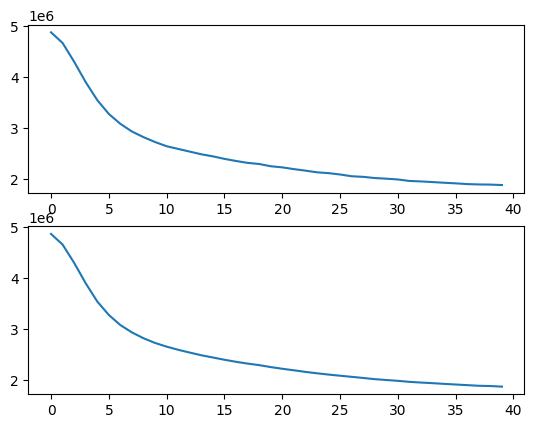

In [142]:
fig, ax = plt.subplots(2)
ax[0].plot(train_loss_list)
ax[1].plot(test_loss_list)

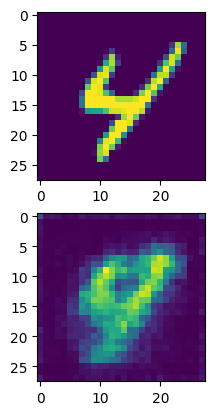

In [155]:
fig, ax = plt.subplots(2)
torch.no_grad()
x_train, y_train = next(iter(train_loader))
x_train = x_train.cuda()
outputs, mu, log_var = model(x_train)
outputs = outputs.cpu().detach().numpy()
ax[0].imshow(x_train.cpu()[0,0])
ax[1].imshow(outputs[0,0])

In [156]:
import pickle
with open('checkpoint2.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)